# Legal Entailment Dataset Exploration

This notebook explores the `EntailmentDatasetBuilder` class.

## Problem/Dataset Overview

**Goal**: Train models to predict whether a set of civil code articles entail (logically support) a legal statement.

**Input**: (Civil code articles, Legal statement)  
**Output**: Y (True) or N (False)


In [5]:
import sys
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from typing import Dict, List, Any
import re
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Add the parent directory to the path so we can import our modules
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))

from multidocqa.entailment_dataset import EntailmentDatasetBuilder
from multidocqa.utils import load_data

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

## 1. Dataset Loading and Basic Statistics

In [7]:
# Load the dataset
# Note: Update this path to point to your actual combined dataset
COMBINED_DATASET_PATH = "../data/processed/complete_dataset.json"

# Check if file exists
if not os.path.exists(COMBINED_DATASET_PATH):
    print(f"Dataset file not found at: {COMBINED_DATASET_PATH}")
    print("Please update the path or create the combined dataset first.")
    # For demonstration, let's create a sample dataset structure
    sample_data = {
        "entailment_pairs": [
            {
                "id": "sample_1",
                "statement": "Sample legal statement 1",
                "articles": [
                    {"number": "101", "content": "Sample article 101 content"},
                    {"number": "102", "content": "Sample article 102 content"}
                ],
                "label": "Y"
            },
            {
                "id": "sample_2",
                "statement": "Sample legal statement 2",
                "articles": [
                    {"number": "103", "content": "Sample article 103 content"}
                ],
                "label": "N"
            }
        ],
        "articles": [
            {"number": "101", "content": "Sample article 101 content"},
            {"number": "102", "content": "Sample article 102 content"},
            {"number": "103", "content": "Sample article 103 content"}
        ]
    }
    
    # Create sample directory and file
    os.makedirs(os.path.dirname(COMBINED_DATASET_PATH), exist_ok=True)
    with open(COMBINED_DATASET_PATH, 'w') as f:
        json.dump(sample_data, f, indent=2)
    print(f"Created sample dataset at: {COMBINED_DATASET_PATH}")

# Load the dataset
builder = EntailmentDatasetBuilder(COMBINED_DATASET_PATH, balance_classes=False)
stats = builder.get_dataset_statistics()

print("📊 Entailment Dataset Statistics")
print("=" * 50)
for key, value in stats.items():
    print(f"{key}: {value}")

📊 Entailment Dataset Statistics
total_samples: 1206
y_samples: 614
n_samples: 592
class_ratio: 614:592
avg_articles_per_statement: 1.2703150912106136
min_articles_per_statement: 1
max_articles_per_statement: 6
unique_articles_used: 573
total_civil_code_articles: 782
most_used_article: ('96', 17)
least_used_article: ('293', 1)
balance_classes: False


## 2. Class Distribution Analysis

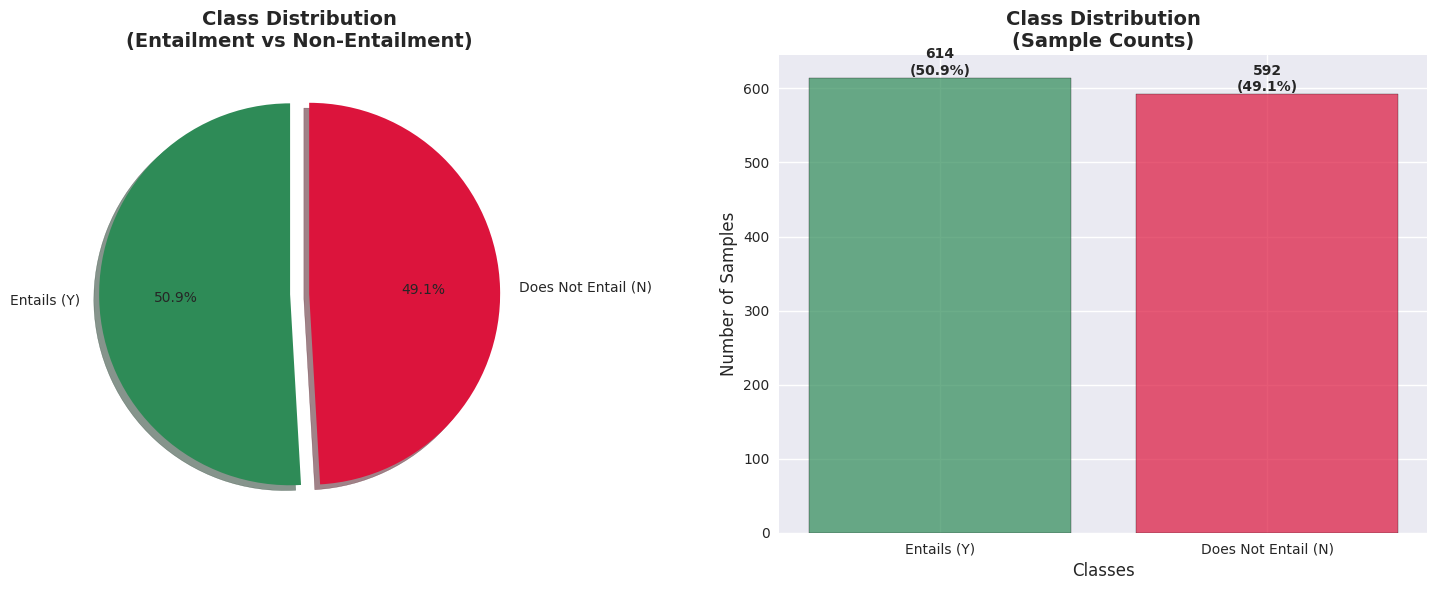


📈 Class Balance Analysis:
Balance Ratio: 0.964 (1.0 = perfectly balanced)
✅ Well-balanced dataset


In [8]:
# Extract class distribution
y_count = stats['y_samples']
n_count = stats['n_samples']
total_samples = stats['total_samples']

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart
labels = ['Entails (Y)', 'Does Not Entail (N)']
sizes = [y_count, n_count]
colors = ['#2E8B57', '#DC143C']
explode = (0.05, 0.05)

axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
            startangle=90, explode=explode, shadow=True)
axes[0].set_title('Class Distribution\n(Entailment vs Non-Entailment)', fontsize=14, fontweight='bold')

# Bar chart
x_pos = np.arange(len(labels))
bars = axes[1].bar(x_pos, sizes, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Classes', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].set_title('Class Distribution\n(Sample Counts)', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(labels)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}\n({height/total_samples*100:.1f}%)',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print class balance insights
balance_ratio = min(y_count, n_count) / max(y_count, n_count)
print(f"\n📈 Class Balance Analysis:")
print(f"Balance Ratio: {balance_ratio:.3f} (1.0 = perfectly balanced)")
if balance_ratio < 0.5:
    print("⚠️  Highly imbalanced dataset - consider class balancing techniques")
elif balance_ratio < 0.8:
    print("⚠️  Moderately imbalanced dataset - monitor model performance")
else:
    print("✅ Well-balanced dataset")

## 3. Article Count Distribution

/tmp/ipykernel_234132/3326958063.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 0].boxplot(data_for_box, labels=labels_for_box, patch_artist=True)


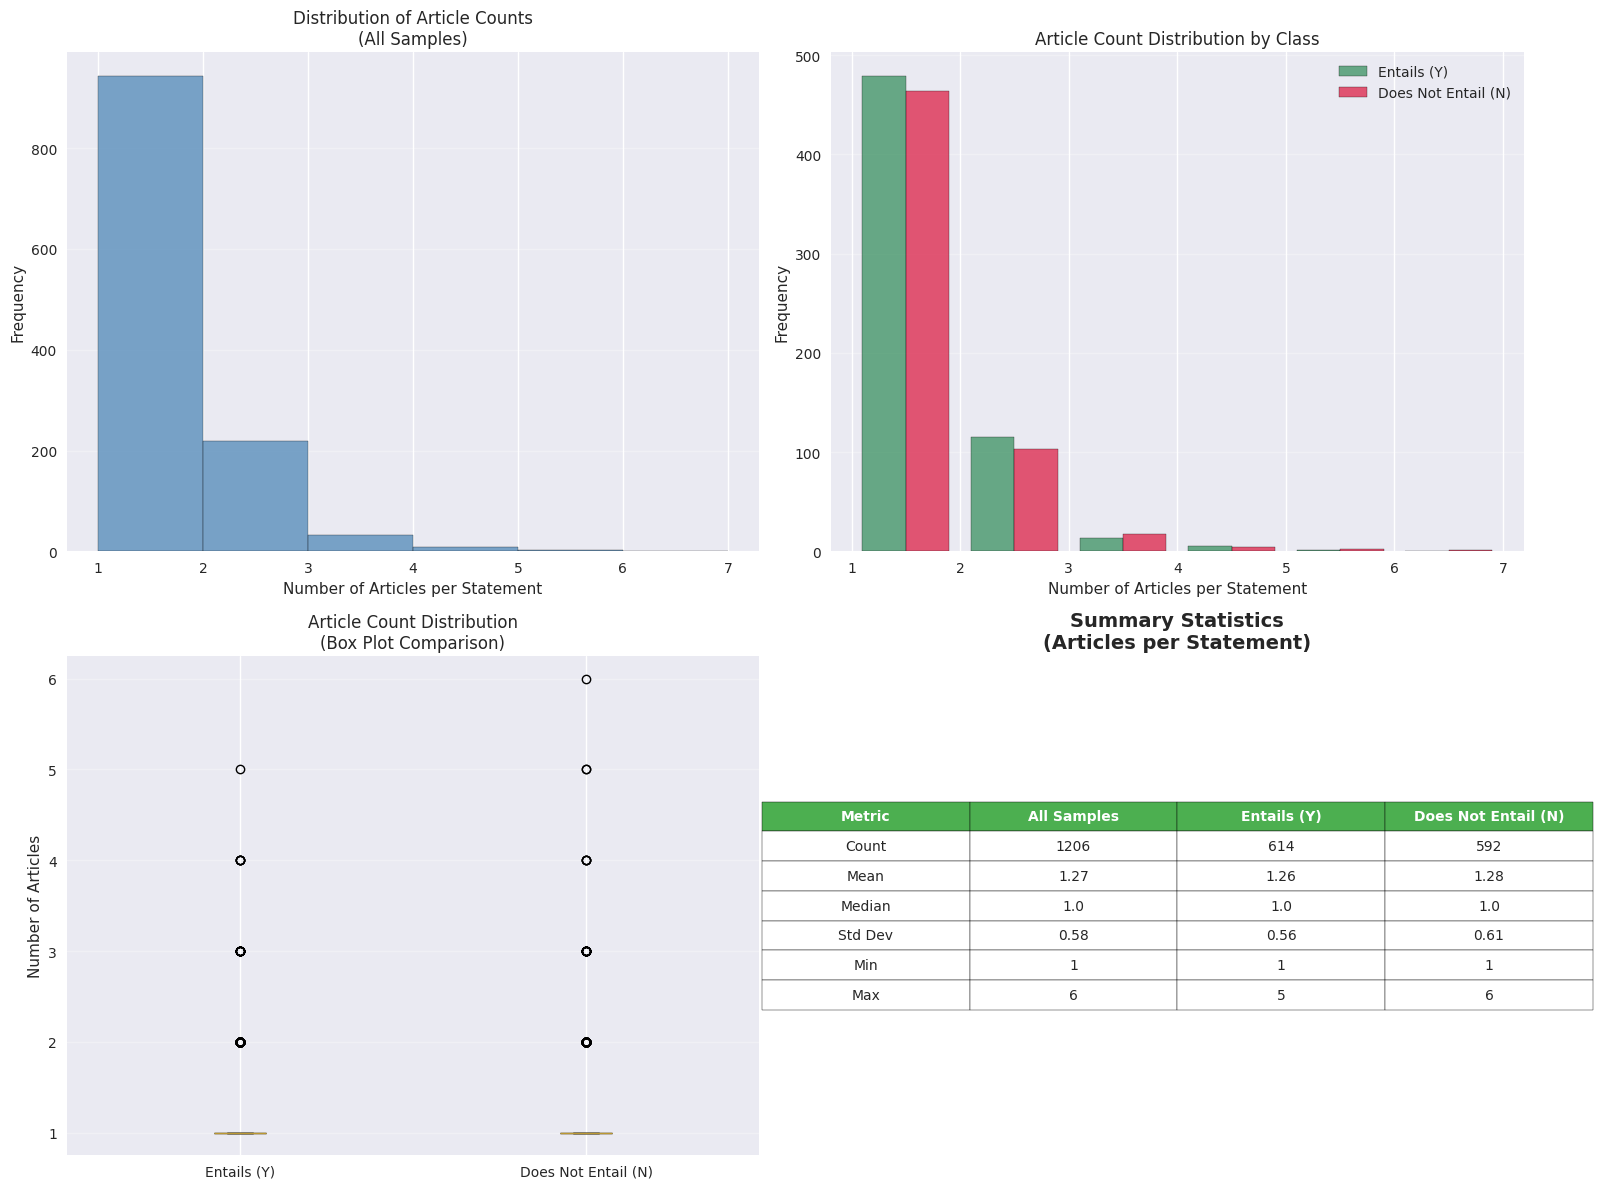


📊 Article Count Insights:
Average articles per statement: 1.27
Most common article count: 1 articles
Range: 1 - 6 articles


In [9]:
# Get article count distribution
samples = builder._generate_entailment_samples()
article_counts = [len(sample['articles']) for sample in samples]
article_counts_by_class = {
    'Y': [len(sample['articles']) for sample in samples if sample['label'] == 'Y'],
    'N': [len(sample['articles']) for sample in samples if sample['label'] == 'N']
}

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Overall distribution histogram
axes[0, 0].hist(article_counts, bins=range(1, max(article_counts) + 2), 
                alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Number of Articles per Statement')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Article Counts\n(All Samples)')
axes[0, 0].grid(axis='y', alpha=0.3)

# By class comparison
bins = range(1, max(article_counts) + 2)
axes[0, 1].hist([article_counts_by_class['Y'], article_counts_by_class['N']], 
                bins=bins, alpha=0.7, label=['Entails (Y)', 'Does Not Entail (N)'],
                color=['#2E8B57', '#DC143C'], edgecolor='black')
axes[0, 1].set_xlabel('Number of Articles per Statement')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Article Count Distribution by Class')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Box plot comparison
data_for_box = [article_counts_by_class['Y'], article_counts_by_class['N']]
labels_for_box = ['Entails (Y)', 'Does Not Entail (N)']
bp = axes[1, 0].boxplot(data_for_box, labels=labels_for_box, patch_artist=True)
bp['boxes'][0].set_facecolor('#2E8B57')
bp['boxes'][1].set_facecolor('#DC143C')
axes[1, 0].set_ylabel('Number of Articles')
axes[1, 0].set_title('Article Count Distribution\n(Box Plot Comparison)')
axes[1, 0].grid(axis='y', alpha=0.3)

# Summary statistics table
axes[1, 1].axis('off')
summary_stats = [
    ['Metric', 'All Samples', 'Entails (Y)', 'Does Not Entail (N)'],
    ['Count', len(article_counts), len(article_counts_by_class['Y']), len(article_counts_by_class['N'])],
    ['Mean', f"{np.mean(article_counts):.2f}", f"{np.mean(article_counts_by_class['Y']):.2f}", f"{np.mean(article_counts_by_class['N']):.2f}"],
    ['Median', f"{np.median(article_counts):.1f}", f"{np.median(article_counts_by_class['Y']):.1f}", f"{np.median(article_counts_by_class['N']):.1f}"],
    ['Std Dev', f"{np.std(article_counts):.2f}", f"{np.std(article_counts_by_class['Y']):.2f}", f"{np.std(article_counts_by_class['N']):.2f}"],
    ['Min', min(article_counts), min(article_counts_by_class['Y']), min(article_counts_by_class['N'])],
    ['Max', max(article_counts), max(article_counts_by_class['Y']), max(article_counts_by_class['N'])]
]

table = axes[1, 1].table(cellText=summary_stats, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Style the header row
for i in range(len(summary_stats[0])):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

axes[1, 1].set_title('Summary Statistics\n(Articles per Statement)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Article Count Insights:")
print(f"Average articles per statement: {np.mean(article_counts):.2f}")
print(f"Most common article count: {Counter(article_counts).most_common(1)[0][0]} articles")
print(f"Range: {min(article_counts)} - {max(article_counts)} articles")

## 4. Article Usage Analysis

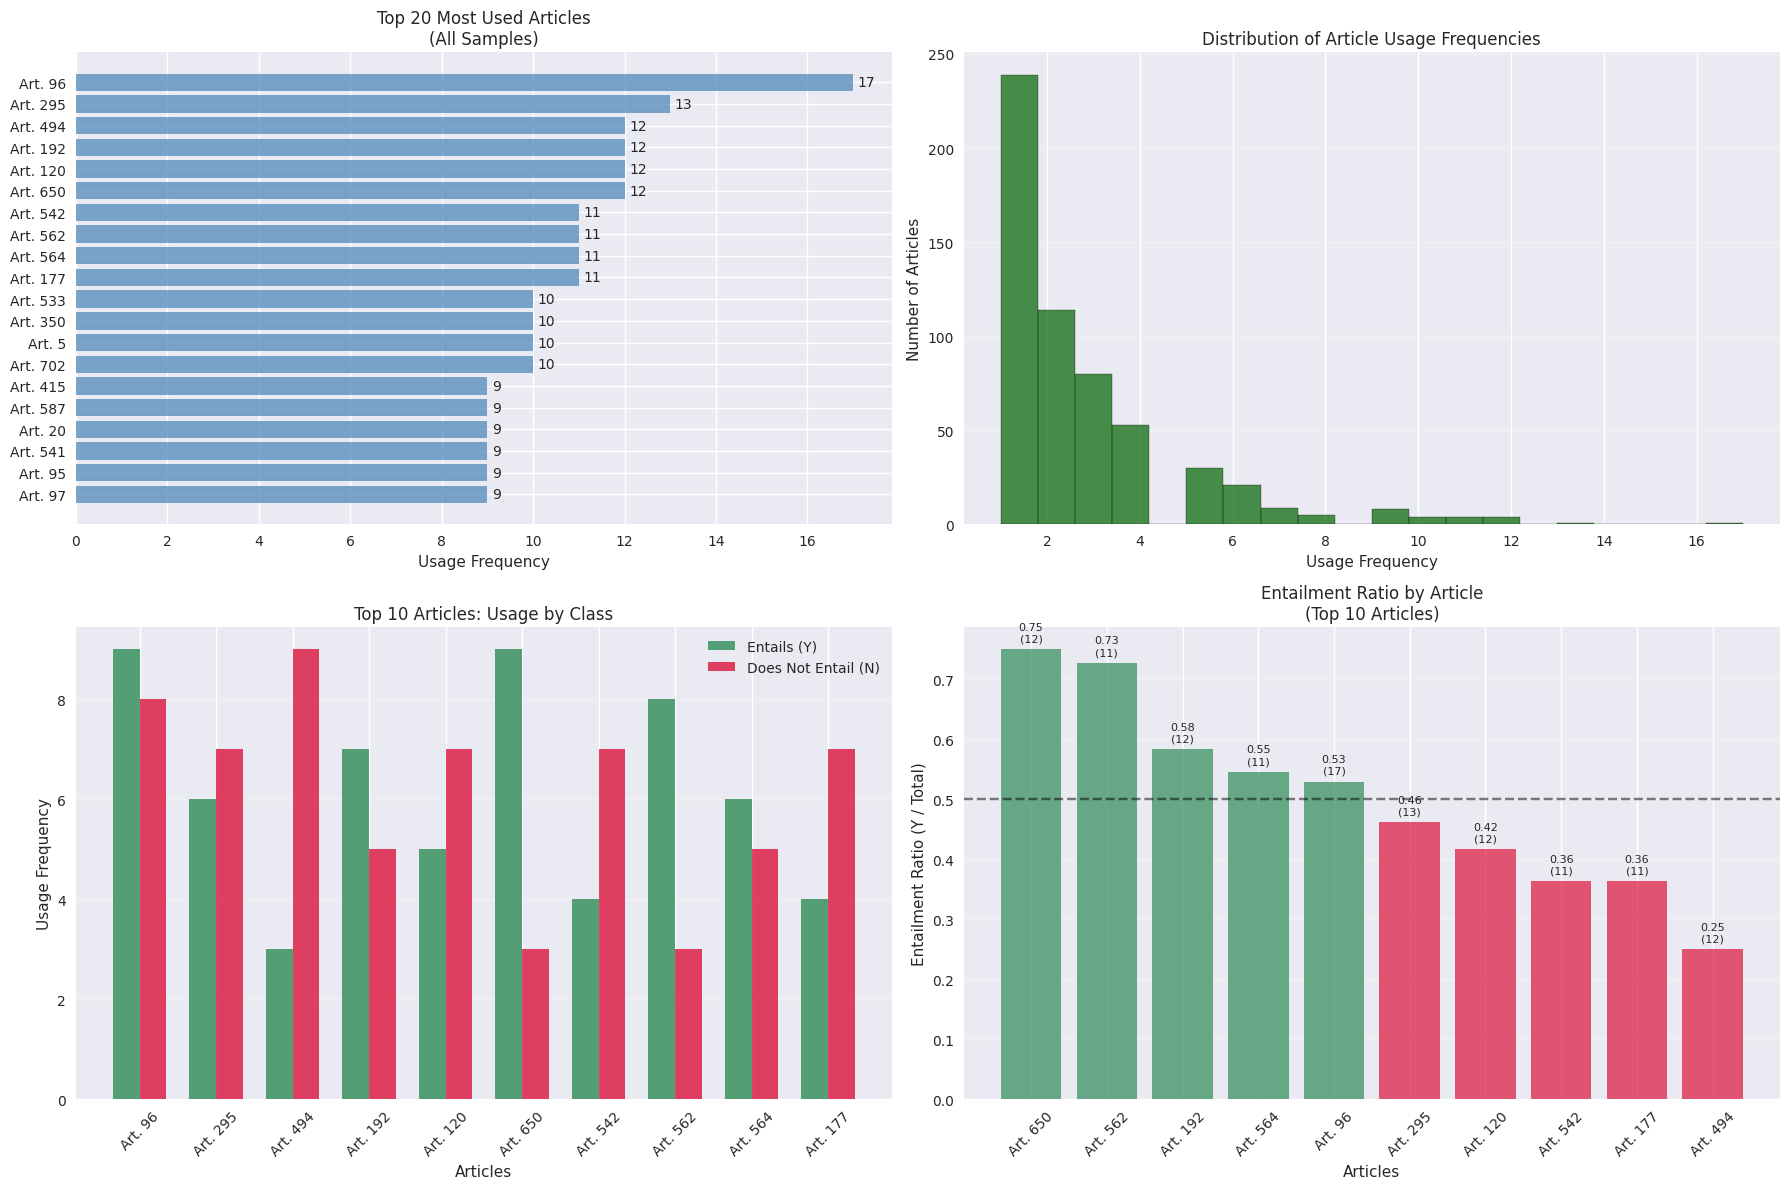


📊 Article Usage Insights:
Total unique articles used: 573
Most used article: 96 (used 17 times)
Least used article: 718 (used 1 times)
Average usage per article: 2.67


In [10]:
# Analyze article usage patterns
article_usage = defaultdict(int)
article_usage_by_class = {'Y': defaultdict(int), 'N': defaultdict(int)}

for sample in samples:
    for article in sample['articles']:
        article_num = article['number']
        article_usage[article_num] += 1
        article_usage_by_class[sample['label']][article_num] += 1

# Convert to sorted lists for visualization
sorted_articles = sorted(article_usage.items(), key=lambda x: x[1], reverse=True)
top_articles = sorted_articles[:20]  # Top 20 most used articles

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top articles usage
articles, counts = zip(*top_articles)
y_pos = np.arange(len(articles))
bars = axes[0, 0].barh(y_pos, counts, color='steelblue', alpha=0.7)
axes[0, 0].set_yticks(y_pos)
axes[0, 0].set_yticklabels([f"Art. {art}" for art in articles])
axes[0, 0].set_xlabel('Usage Frequency')
axes[0, 0].set_title('Top 20 Most Used Articles\n(All Samples)')
axes[0, 0].invert_yaxis()

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    axes[0, 0].text(width + 0.1, bar.get_y() + bar.get_height()/2,
                   f'{int(width)}', ha='left', va='center')

# Usage distribution histogram
usage_counts = list(article_usage.values())
axes[0, 1].hist(usage_counts, bins=20, alpha=0.7, color='darkgreen', edgecolor='black')
axes[0, 1].set_xlabel('Usage Frequency')
axes[0, 1].set_ylabel('Number of Articles')
axes[0, 1].set_title('Distribution of Article Usage Frequencies')
axes[0, 1].grid(axis='y', alpha=0.3)

# Class-specific usage for top articles
top_10_articles = [art for art, _ in top_articles[:10]]
y_usage = [article_usage_by_class['Y'][art] for art in top_10_articles]
n_usage = [article_usage_by_class['N'][art] for art in top_10_articles]

x = np.arange(len(top_10_articles))
width = 0.35

axes[1, 0].bar(x - width/2, y_usage, width, label='Entails (Y)', color='#2E8B57', alpha=0.8)
axes[1, 0].bar(x + width/2, n_usage, width, label='Does Not Entail (N)', color='#DC143C', alpha=0.8)
axes[1, 0].set_xlabel('Articles')
axes[1, 0].set_ylabel('Usage Frequency')
axes[1, 0].set_title('Top 10 Articles: Usage by Class')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([f"Art. {art}" for art in top_10_articles], rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Create usage ratio analysis
usage_ratios = []
for art in top_10_articles:
    y_count = article_usage_by_class['Y'][art]
    n_count = article_usage_by_class['N'][art]
    if y_count + n_count > 0:
        ratio = y_count / (y_count + n_count)
        usage_ratios.append((art, ratio, y_count + n_count))

usage_ratios.sort(key=lambda x: x[1], reverse=True)
articles_ratio, ratios, total_usage = zip(*usage_ratios)

colors = ['#2E8B57' if r > 0.5 else '#DC143C' for r in ratios]
bars = axes[1, 1].bar(range(len(articles_ratio)), ratios, color=colors, alpha=0.7)
axes[1, 1].set_xlabel('Articles')
axes[1, 1].set_ylabel('Entailment Ratio (Y / Total)')
axes[1, 1].set_title('Entailment Ratio by Article\n(Top 10 Articles)')
axes[1, 1].set_xticks(range(len(articles_ratio)))
axes[1, 1].set_xticklabels([f"Art. {art}" for art in articles_ratio], rotation=45)
axes[1, 1].axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add ratio labels
for i, (bar, ratio, total) in enumerate(zip(bars, ratios, total_usage)):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{ratio:.2f}\n({total})',
                   ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print(f"\n📊 Article Usage Insights:")
print(f"Total unique articles used: {len(article_usage)}")
print(f"Most used article: {sorted_articles[0][0]} (used {sorted_articles[0][1]} times)")
print(f"Least used article: {sorted_articles[-1][0]} (used {sorted_articles[-1][1]} times)")
print(f"Average usage per article: {np.mean(list(article_usage.values())):.2f}")

## 5. Statement Length and Complexity Analysis

/tmp/ipykernel_234132/2485058819.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 0].boxplot(sentence_data, labels=['Entails (Y)', 'Does Not Entail (N)'],
/tmp/ipykernel_234132/2485058819.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1, 1].boxplot(avg_word_length_data, labels=['Entails (Y)', 'Does Not Entail (N)'],


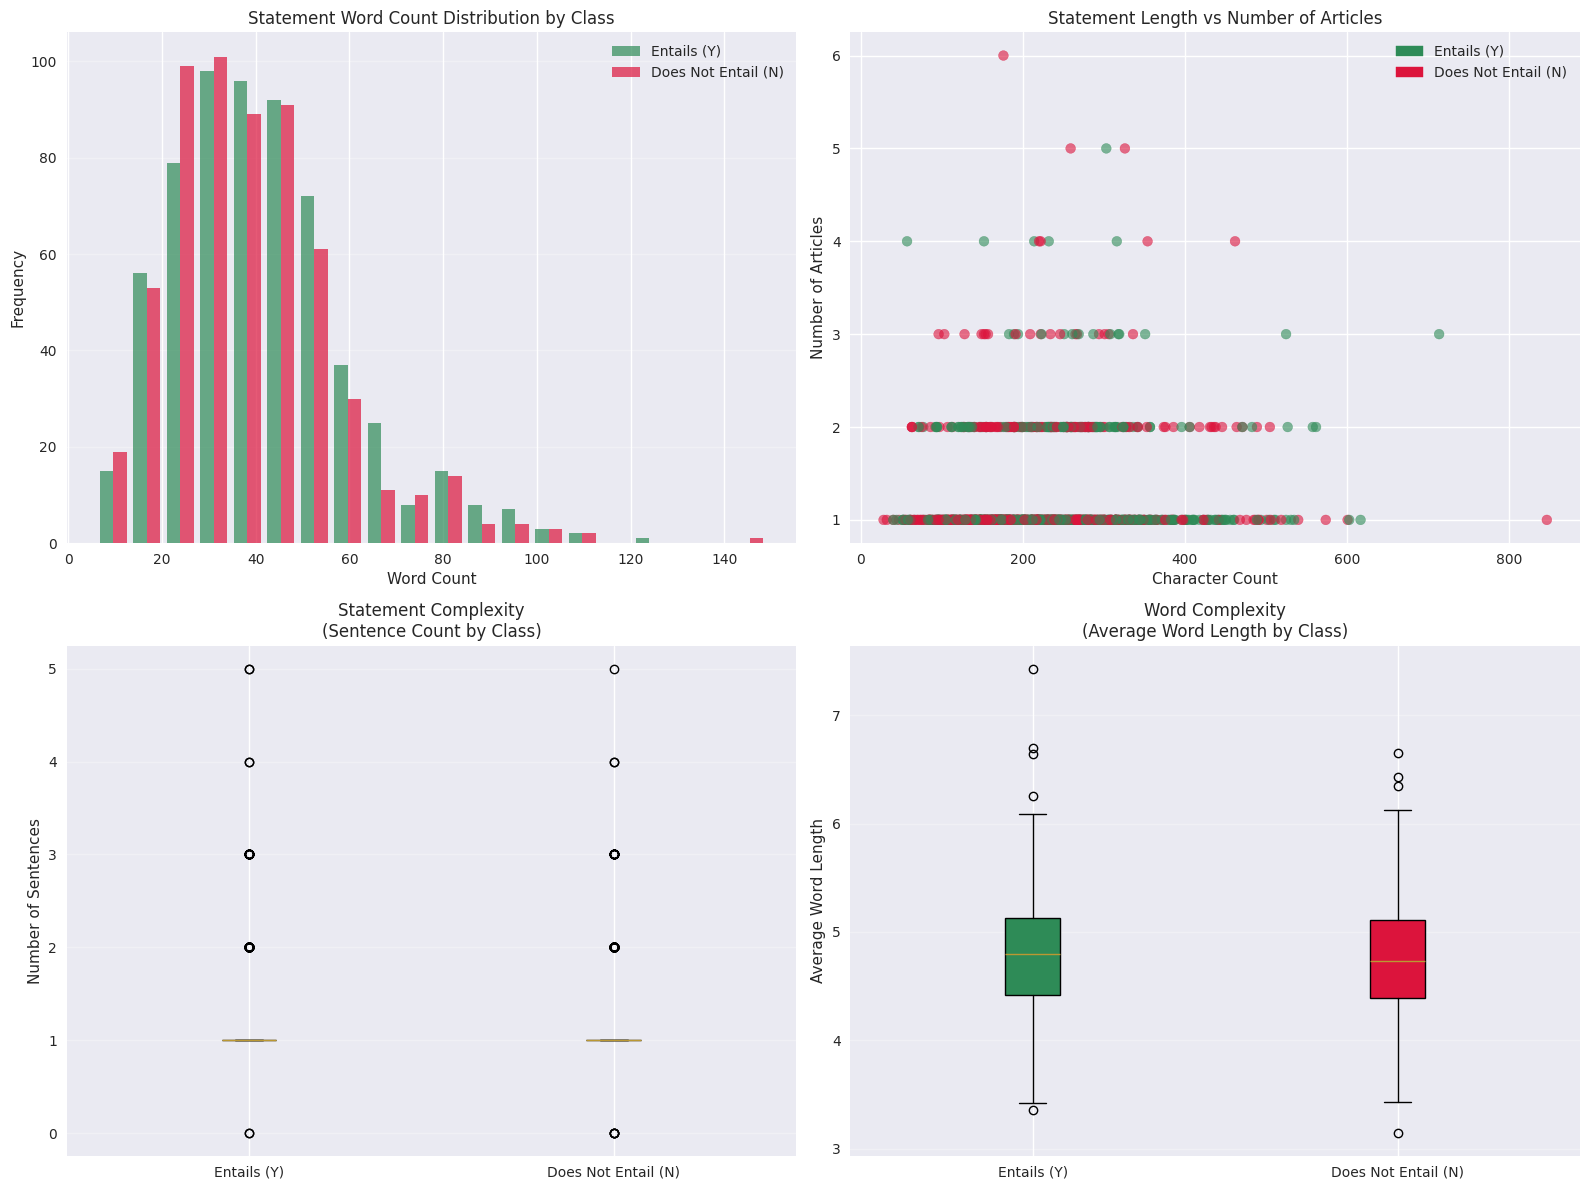


📊 Statement Analysis Summary:

Word Count:
  All: 40.2 ± 18.6
  Entails (Y): 41.3 ± 18.9
  Does Not Entail (N): 39.2 ± 18.4

Character Count:
  All: 227.6 ± 99.5
  Range: 28 - 847

Sentence Count:
  All: 1.2 ± 0.5
  Range: 0 - 5


In [11]:
# Analyze statement characteristics
statement_stats = []
for sample in samples:
    statement = sample['statement']
    stats_row = {
        'statement_id': sample['statement_id'],
        'label': sample['label'],
        'char_count': len(statement),
        'word_count': len(statement.split()),
        'sentence_count': len(re.split(r'[.!?]+', statement)) - 1,
        'avg_word_length': np.mean([len(word) for word in statement.split()]),
        'question_marks': statement.count('?'),
        'exclamation_marks': statement.count('!'),
        'num_articles': len(sample['articles'])
    }
    statement_stats.append(stats_row)

df_stats = pd.DataFrame(statement_stats)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Word count distribution by class
y_words = df_stats[df_stats['label'] == 'Y']['word_count']
n_words = df_stats[df_stats['label'] == 'N']['word_count']

axes[0, 0].hist([y_words, n_words], bins=20, alpha=0.7, 
                label=['Entails (Y)', 'Does Not Entail (N)'],
                color=['#2E8B57', '#DC143C'])
axes[0, 0].set_xlabel('Word Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Statement Word Count Distribution by Class')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Character count vs number of articles
scatter = axes[0, 1].scatter(df_stats['char_count'], df_stats['num_articles'], 
                            c=df_stats['label'].map({'Y': '#2E8B57', 'N': '#DC143C'}),
                            alpha=0.6, s=50)
axes[0, 1].set_xlabel('Character Count')
axes[0, 1].set_ylabel('Number of Articles')
axes[0, 1].set_title('Statement Length vs Number of Articles')

# Create custom legend
y_patch = plt.matplotlib.patches.Patch(color='#2E8B57', label='Entails (Y)')
n_patch = plt.matplotlib.patches.Patch(color='#DC143C', label='Does Not Entail (N)')
axes[0, 1].legend(handles=[y_patch, n_patch])

# Sentence count comparison
sentence_data = [df_stats[df_stats['label'] == 'Y']['sentence_count'],
                df_stats[df_stats['label'] == 'N']['sentence_count']]
bp = axes[1, 0].boxplot(sentence_data, labels=['Entails (Y)', 'Does Not Entail (N)'], 
                        patch_artist=True)
bp['boxes'][0].set_facecolor('#2E8B57')
bp['boxes'][1].set_facecolor('#DC143C')
axes[1, 0].set_ylabel('Number of Sentences')
axes[1, 0].set_title('Statement Complexity\n(Sentence Count by Class)')
axes[1, 0].grid(axis='y', alpha=0.3)

# Average word length comparison
avg_word_length_data = [df_stats[df_stats['label'] == 'Y']['avg_word_length'],
                       df_stats[df_stats['label'] == 'N']['avg_word_length']]
bp2 = axes[1, 1].boxplot(avg_word_length_data, labels=['Entails (Y)', 'Does Not Entail (N)'], 
                         patch_artist=True)
bp2['boxes'][0].set_facecolor('#2E8B57')
bp2['boxes'][1].set_facecolor('#DC143C')
axes[1, 1].set_ylabel('Average Word Length')
axes[1, 1].set_title('Word Complexity\n(Average Word Length by Class)')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n📊 Statement Analysis Summary:")
print(f"\nWord Count:")
print(f"  All: {df_stats['word_count'].mean():.1f} ± {df_stats['word_count'].std():.1f}")
print(f"  Entails (Y): {y_words.mean():.1f} ± {y_words.std():.1f}")
print(f"  Does Not Entail (N): {n_words.mean():.1f} ± {n_words.std():.1f}")

print(f"\nCharacter Count:")
print(f"  All: {df_stats['char_count'].mean():.1f} ± {df_stats['char_count'].std():.1f}")
print(f"  Range: {df_stats['char_count'].min()} - {df_stats['char_count'].max()}")

print(f"\nSentence Count:")
print(f"  All: {df_stats['sentence_count'].mean():.1f} ± {df_stats['sentence_count'].std():.1f}")
print(f"  Range: {df_stats['sentence_count'].min()} - {df_stats['sentence_count'].max()}")

## 6. Prompt Analysis

🔍 Sample Prompts Analysis

📝 Sample 1 (Label: Y)
Articles: 1
Statement ID: R02-25-A

Prompt Preview (first 500 chars):
--------------------------------------------------

You are a legal reasoning AI. Given a list of Civil Code articles and a legal statement,
your task is to determine whether the articles entail the statement as true (Y) or not (N).
Repeatedly check and refine your reasoning and conclusions until you reach a final conclusion.  # noqa: E501

Respond strictly with 'Y' or 'N'.

Civil Code articles:
Article 605-2: (1) If a lease is perfected in accordance with the laws and regulations including the preceding Article, and Articles 10 and 31 of the Ac...
--------------------------------------------------

📝 Sample 2 (Label: Y)
Articles: 1
Statement ID: R04-18-U

Prompt Preview (first 500 chars):
--------------------------------------------------

You are a legal reasoning AI. Given a list of Civil Code articles and a legal statement,
your task is to determine whether the art

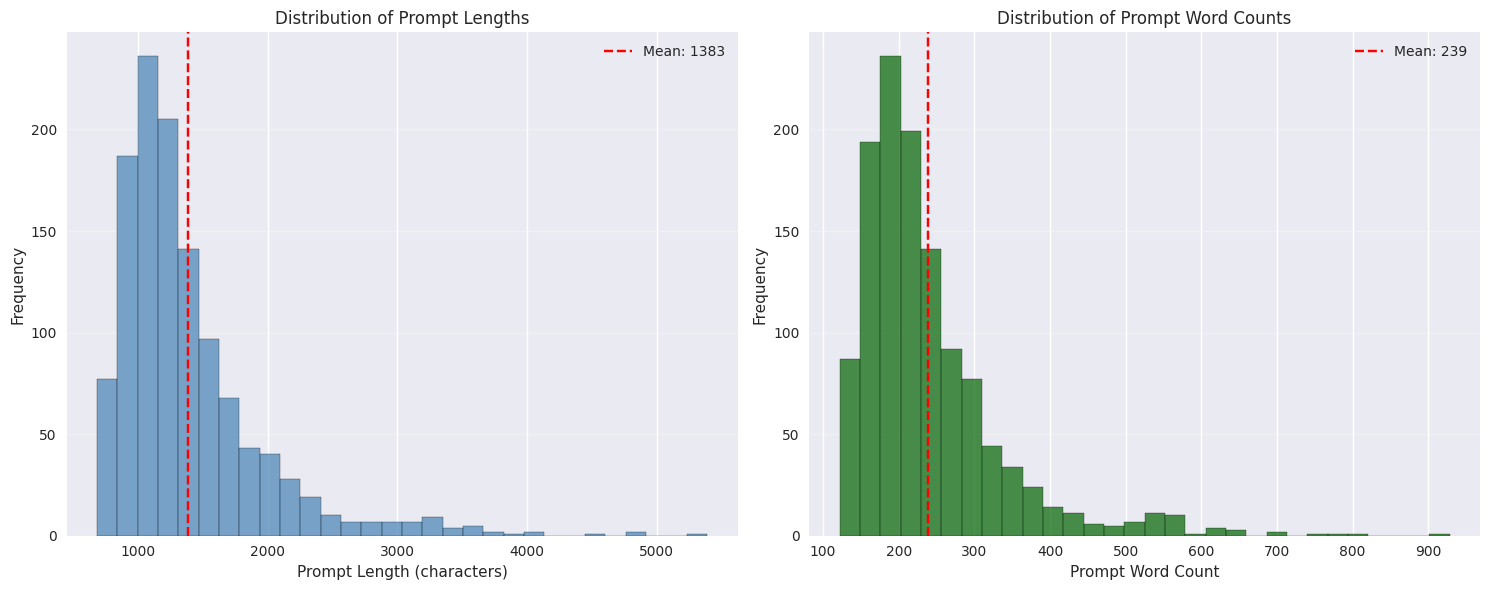


📊 Prompt Statistics:
Average prompt length: 1383 characters
Average prompt word count: 239 words
Longest prompt: 5,389 characters
Shortest prompt: 683 characters

Estimated token usage:
Average tokens per prompt: 346
Max tokens per prompt: 1347
95th percentile: 622 tokens


In [12]:
# Generate sample prompts to analyze
train_dataset, _ = builder.build_entailment_dataset(split_ratio=1.0)
sample_prompts = [train_dataset[i] for i in range(min(5, len(train_dataset)))]

print("🔍 Sample Prompts Analysis")
print("=" * 60)

for i, prompt_data in enumerate(sample_prompts):
    print(f"\n📝 Sample {i+1} (Label: {prompt_data['reference']})")
    print(f"Articles: {prompt_data['num_articles']}")
    print(f"Statement ID: {prompt_data['statement_id']}")
    print(f"\nPrompt Preview (first 500 chars):")
    print("-" * 50)
    print(prompt_data['prompt'][:500] + "..." if len(prompt_data['prompt']) > 500 else prompt_data['prompt'])
    print("-" * 50)

# Analyze prompt characteristics
prompt_lengths = [len(item['prompt']) for item in train_dataset]
prompt_word_counts = [len(item['prompt'].split()) for item in train_dataset]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Prompt length distribution
axes[0].hist(prompt_lengths, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Prompt Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Prompt Lengths')
axes[0].grid(axis='y', alpha=0.3)
axes[0].axvline(np.mean(prompt_lengths), color='red', linestyle='--', 
               label=f'Mean: {np.mean(prompt_lengths):.0f}')
axes[0].legend()

# Prompt word count distribution
axes[1].hist(prompt_word_counts, bins=30, alpha=0.7, color='darkgreen', edgecolor='black')
axes[1].set_xlabel('Prompt Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Prompt Word Counts')
axes[1].grid(axis='y', alpha=0.3)
axes[1].axvline(np.mean(prompt_word_counts), color='red', linestyle='--',
               label=f'Mean: {np.mean(prompt_word_counts):.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n📊 Prompt Statistics:")
print(f"Average prompt length: {np.mean(prompt_lengths):.0f} characters")
print(f"Average prompt word count: {np.mean(prompt_word_counts):.0f} words")
print(f"Longest prompt: {max(prompt_lengths):,} characters")
print(f"Shortest prompt: {min(prompt_lengths):,} characters")

# Token estimation (rough approximation: 1 token ≈ 4 characters)
estimated_tokens = [length / 4 for length in prompt_lengths]
print(f"\nEstimated token usage:")
print(f"Average tokens per prompt: {np.mean(estimated_tokens):.0f}")
print(f"Max tokens per prompt: {max(estimated_tokens):.0f}")
print(f"95th percentile: {np.percentile(estimated_tokens, 95):.0f} tokens")

## 7. Dataset Quality Assessment

🔍 Dataset Quality Assessment

📋 Duplicate Analysis:
Total samples: 1206
Unique statement IDs: 1206
Duplicate statement IDs: 0

📏 Statement Length Quality:
Average statement length: 228 characters
Statements < 50 chars: 6
Statements > 1000 chars: 0

📄 Article Quality:
Articles with < 50 characters: 0

📊 Class Distribution by Article Count:
  1 articles: 479 Y, 464 N (Y ratio: 0.51)
  2 articles: 115 Y, 103 N (Y ratio: 0.53)
  3 articles: 14 Y, 18 N (Y ratio: 0.44)
  4 articles: 5 Y, 4 N (Y ratio: 0.56)
  5 articles: 1 Y, 2 N (Y ratio: 0.33)
  6 articles: 0 Y, 1 N (Y ratio: 0.00)


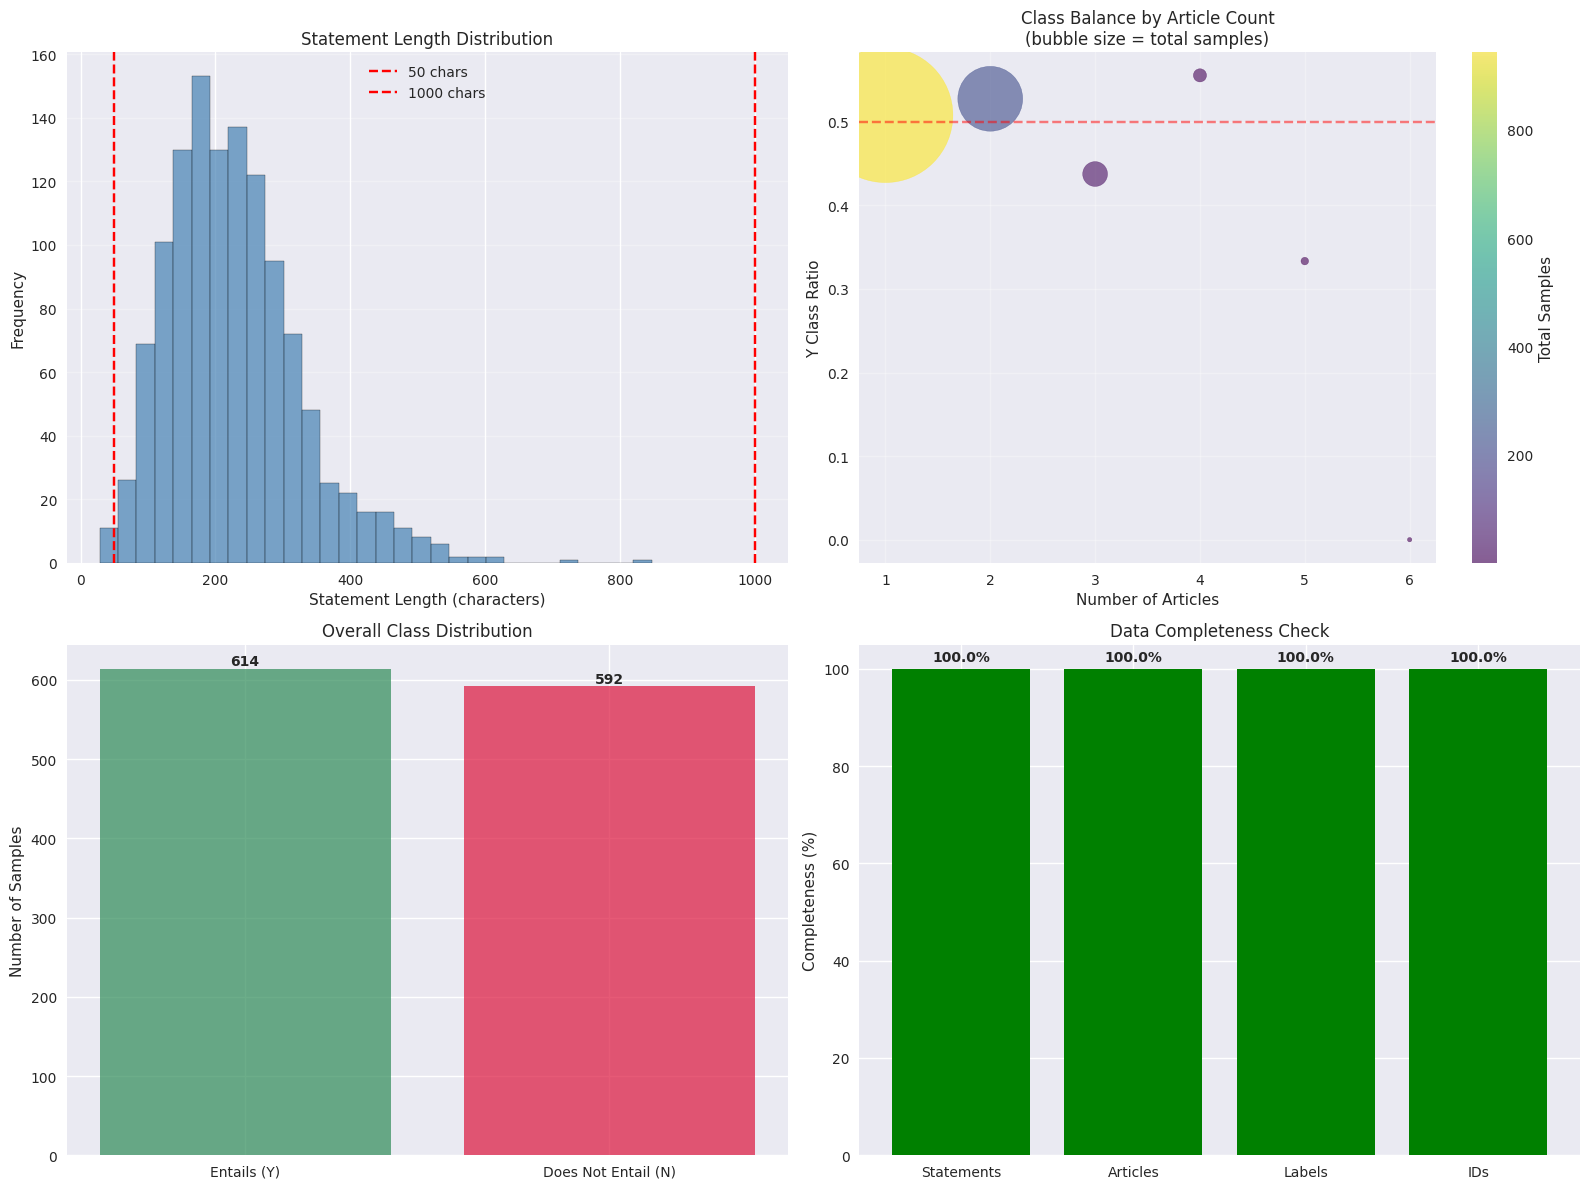


✅ Data Quality Summary:
Overall data completeness: 100.0%
Class balance score: 0.964 (1.0 = perfect balance)
Average articles per sample: 3.5
Dataset size: 1206 samples


In [13]:
# Analyze dataset quality metrics
print("🔍 Dataset Quality Assessment")
print("=" * 50)

# Check for duplicates
statement_ids = [sample['statement_id'] for sample in samples]
duplicate_ids = [id for id in statement_ids if statement_ids.count(id) > 1]
print(f"\n📋 Duplicate Analysis:")
print(f"Total samples: {len(samples)}")
print(f"Unique statement IDs: {len(set(statement_ids))}")
print(f"Duplicate statement IDs: {len(set(duplicate_ids))}")

# Check statement length distribution
statement_lengths = [len(sample['statement']) for sample in samples]
print(f"\n📏 Statement Length Quality:")
print(f"Average statement length: {np.mean(statement_lengths):.0f} characters")
print(f"Statements < 50 chars: {sum(1 for l in statement_lengths if l < 50)}")
print(f"Statements > 1000 chars: {sum(1 for l in statement_lengths if l > 1000)}")

# Check for empty or very short articles
short_articles = []
for sample in samples:
    for article in sample['articles']:
        if len(article['content']) < 50:
            short_articles.append(article['number'])

print(f"\n📄 Article Quality:")
print(f"Articles with < 50 characters: {len(short_articles)}")
if short_articles:
    print(f"Short articles: {set(short_articles)}")

# Check class distribution by article count
class_by_article_count = defaultdict(lambda: {'Y': 0, 'N': 0})
for sample in samples:
    count = len(sample['articles'])
    class_by_article_count[count][sample['label']] += 1

print(f"\n📊 Class Distribution by Article Count:")
for count in sorted(class_by_article_count.keys()):
    y_count = class_by_article_count[count]['Y']
    n_count = class_by_article_count[count]['N']
    total = y_count + n_count
    print(f"  {count} articles: {y_count} Y, {n_count} N (Y ratio: {y_count/total:.2f})")

# Visualize quality metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Statement length distribution
axes[0, 0].hist(statement_lengths, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Statement Length (characters)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Statement Length Distribution')
axes[0, 0].axvline(50, color='red', linestyle='--', label='50 chars')
axes[0, 0].axvline(1000, color='red', linestyle='--', label='1000 chars')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Article count vs class distribution
article_counts = list(class_by_article_count.keys())
y_ratios = [class_by_article_count[count]['Y'] / (class_by_article_count[count]['Y'] + class_by_article_count[count]['N']) 
           for count in article_counts]
total_samples = [class_by_article_count[count]['Y'] + class_by_article_count[count]['N'] 
                for count in article_counts]

scatter = axes[0, 1].scatter(article_counts, y_ratios, s=[s*10 for s in total_samples], 
                            alpha=0.6, c=total_samples, cmap='viridis')
axes[0, 1].set_xlabel('Number of Articles')
axes[0, 1].set_ylabel('Y Class Ratio')
axes[0, 1].set_title('Class Balance by Article Count\n(bubble size = total samples)')
axes[0, 1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
axes[0, 1].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 1], label='Total Samples')

# Sample distribution by class
class_counts = [stats['y_samples'], stats['n_samples']]
class_labels = ['Entails (Y)', 'Does Not Entail (N)']
colors = ['#2E8B57', '#DC143C']

bars = axes[1, 0].bar(class_labels, class_counts, color=colors, alpha=0.7)
axes[1, 0].set_ylabel('Number of Samples')
axes[1, 0].set_title('Overall Class Distribution')
for bar, count in zip(bars, class_counts):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                   f'{count}', ha='center', va='bottom', fontweight='bold')

# Data completeness check
completeness_metrics = ['Statements', 'Articles', 'Labels', 'IDs']
completeness_values = [
    len([s for s in samples if s['statement'].strip()]),
    len([s for s in samples if s['articles']]),
    len([s for s in samples if s['label'] in ['Y', 'N']]),
    len([s for s in samples if s['statement_id'].strip()])
]
completeness_percentages = [v/len(samples)*100 for v in completeness_values]

bars = axes[1, 1].bar(completeness_metrics, completeness_percentages, 
                     color=['green' if p == 100 else 'orange' if p > 95 else 'red' 
                           for p in completeness_percentages])
axes[1, 1].set_ylabel('Completeness (%)')
axes[1, 1].set_title('Data Completeness Check')
axes[1, 1].set_ylim(0, 105)
for bar, percentage in zip(bars, completeness_percentages):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                   f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Data Quality Summary:")
print(f"Overall data completeness: {min(completeness_percentages):.1f}%")
balance_score = min(stats['y_samples'], stats['n_samples']) / max(stats['y_samples'], stats['n_samples'])
print(f"Class balance score: {balance_score:.3f} (1.0 = perfect balance)")
print(f"Average articles per sample: {np.mean(article_counts):.1f}")
print(f"Dataset size: {len(samples)} samples")

## 8. Recommendations and Next Steps

🎯 Dataset Analysis Recommendations

1. 🎯 Training Strategy [Medium Priority]
   Issue: Entailment task complexity
   Recommendation: Use curriculum learning: start with simpler cases (fewer articles) and progress to complex ones

2. 🔧 Model Architecture [Medium Priority]
   Issue: Multiple article processing
   Recommendation: Consider attention mechanisms or hierarchical processing for multi-article inputs

3. 📈 Evaluation [High Priority]
   Issue: Binary classification task
   Recommendation: Use precision, recall, F1-score for both classes, and consider AUC-ROC for evaluation


🚀 Next Steps:
1. Implement class balancing if needed
2. Set up proper train/validation/test splits
3. Design prompt templates optimized for entailment
4. Implement curriculum learning strategy
5. Set up comprehensive evaluation metrics
6. Consider multi-task learning with relevance prediction


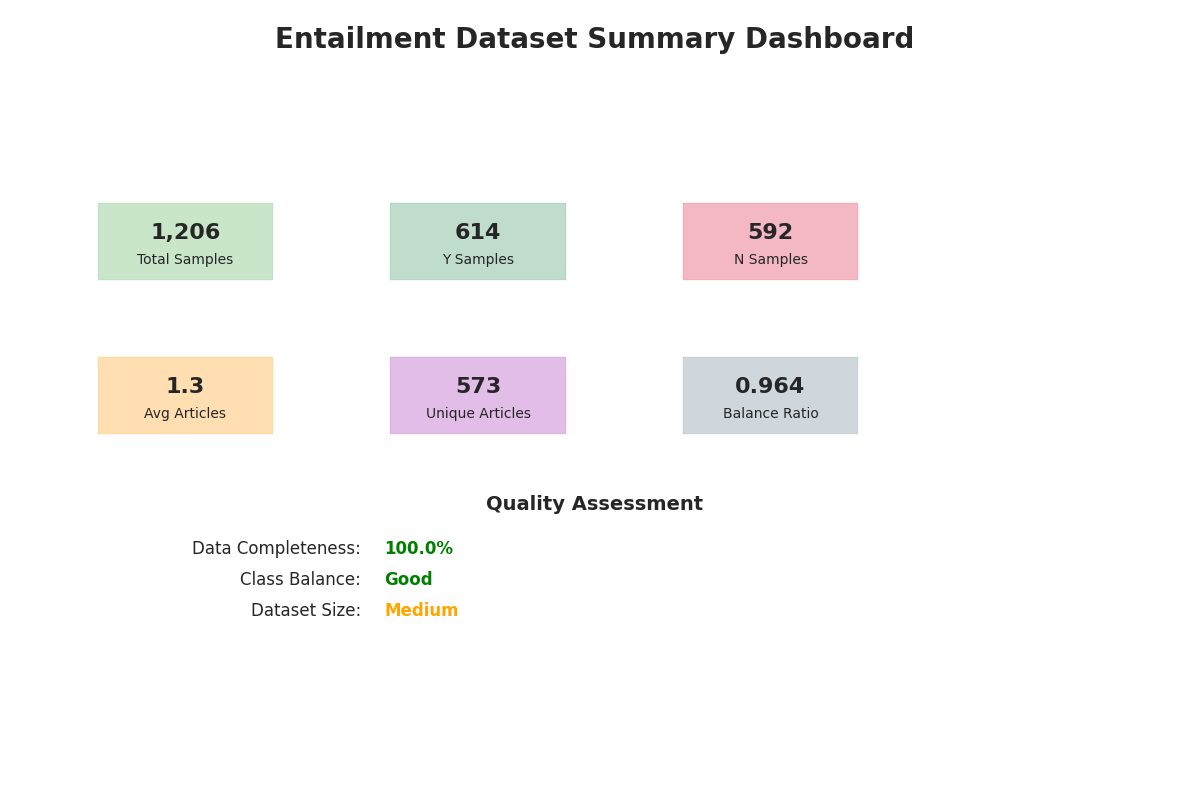


🎉 Analysis Complete!
Dataset is ready for training with 1206 samples.


In [14]:
# Generate actionable recommendations based on analysis
print("🎯 Dataset Analysis Recommendations")
print("=" * 60)

recommendations = []

# Class balance recommendation
balance_ratio = min(stats['y_samples'], stats['n_samples']) / max(stats['y_samples'], stats['n_samples'])
if balance_ratio < 0.5:
    recommendations.append({
        'category': '⚖️ Class Balance',
        'issue': f'Highly imbalanced dataset (ratio: {balance_ratio:.3f})',
        'recommendation': 'Consider class balancing techniques like oversampling minority class or undersampling majority class',
        'priority': 'High'
    })
elif balance_ratio < 0.8:
    recommendations.append({
        'category': '⚖️ Class Balance',
        'issue': f'Moderately imbalanced dataset (ratio: {balance_ratio:.3f})',
        'recommendation': 'Monitor model performance and consider weighted loss functions',
        'priority': 'Medium'
    })

# Token length recommendation
avg_prompt_length = np.mean([len(item['prompt']) for item in train_dataset])
if avg_prompt_length > 8000:  # ~2000 tokens
    recommendations.append({
        'category': '📏 Prompt Length',
        'issue': f'Long prompts (avg: {avg_prompt_length:.0f} chars)',
        'recommendation': 'Consider truncation strategies or hierarchical processing for long contexts',
        'priority': 'Medium'
    })

# Article count variability
article_count_std = np.std([len(sample['articles']) for sample in samples])
if article_count_std > 2:
    recommendations.append({
        'category': '📄 Article Variability',
        'issue': f'High variability in article counts (std: {article_count_std:.1f})',
        'recommendation': 'Consider stratified sampling or padding strategies to handle variable input sizes',
        'priority': 'Low'
    })

# Dataset size recommendation
if len(samples) < 1000:
    recommendations.append({
        'category': '📊 Dataset Size',
        'issue': f'Small dataset size ({len(samples)} samples)',
        'recommendation': 'Consider data augmentation, transfer learning, or few-shot learning approaches',
        'priority': 'High'
    })

# Training recommendations
recommendations.extend([
    {
        'category': '🎯 Training Strategy',
        'issue': 'Entailment task complexity',
        'recommendation': 'Use curriculum learning: start with simpler cases (fewer articles) and progress to complex ones',
        'priority': 'Medium'
    },
    {
        'category': '🔧 Model Architecture',
        'issue': 'Multiple article processing',
        'recommendation': 'Consider attention mechanisms or hierarchical processing for multi-article inputs',
        'priority': 'Medium'
    },
    {
        'category': '📈 Evaluation',
        'issue': 'Binary classification task',
        'recommendation': 'Use precision, recall, F1-score for both classes, and consider AUC-ROC for evaluation',
        'priority': 'High'
    }
])

# Display recommendations
for i, rec in enumerate(recommendations, 1):
    print(f"\n{i}. {rec['category']} [{rec['priority']} Priority]")
    print(f"   Issue: {rec['issue']}")
    print(f"   Recommendation: {rec['recommendation']}")

print(f"\n\n🚀 Next Steps:")
print("1. Implement class balancing if needed")
print("2. Set up proper train/validation/test splits")
print("3. Design prompt templates optimized for entailment")
print("4. Implement curriculum learning strategy")
print("5. Set up comprehensive evaluation metrics")
print("6. Consider multi-task learning with relevance prediction")

# Create final summary visualization
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Create summary dashboard
ax.axis('off')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

# Title
ax.text(5, 9.5, 'Entailment Dataset Summary Dashboard', 
        fontsize=20, fontweight='bold', ha='center')

# Key metrics boxes
metrics_data = [
    ('Total Samples', f"{len(samples):,}", '#4CAF50'),
    ('Y Samples', f"{stats['y_samples']:,}", '#2E8B57'),
    ('N Samples', f"{stats['n_samples']:,}", '#DC143C'),
    ('Avg Articles', f"{np.mean([len(s['articles']) for s in samples]):.1f}", '#FF9800'),
    ('Unique Articles', f"{len(article_usage)}", '#9C27B0'),
    ('Balance Ratio', f"{balance_ratio:.3f}", '#607D8B')
]

for i, (label, value, color) in enumerate(metrics_data):
    x = 1.5 + (i % 3) * 2.5
    y = 7 - (i // 3) * 2
    
    # Draw box
    rect = plt.Rectangle((x-0.75, y-0.5), 1.5, 1, facecolor=color, alpha=0.3, edgecolor=color)
    ax.add_patch(rect)
    
    # Add text
    ax.text(x, y+0.1, value, fontsize=16, fontweight='bold', ha='center', va='center')
    ax.text(x, y-0.25, label, fontsize=10, ha='center', va='center')

# Add quality indicators
quality_indicators = [
    ('Data Completeness', f"{min(completeness_percentages):.1f}%", 'green' if min(completeness_percentages) > 95 else 'orange'),
    ('Class Balance', 'Good' if balance_ratio > 0.8 else 'Moderate' if balance_ratio > 0.5 else 'Poor', 
     'green' if balance_ratio > 0.8 else 'orange' if balance_ratio > 0.5 else 'red'),
    ('Dataset Size', 'Large' if len(samples) > 10000 else 'Medium' if len(samples) > 1000 else 'Small',
     'green' if len(samples) > 10000 else 'orange' if len(samples) > 1000 else 'red')
]

ax.text(5, 3.5, 'Quality Assessment', fontsize=14, fontweight='bold', ha='center')
for i, (label, status, color) in enumerate(quality_indicators):
    y = 3 - i * 0.4
    ax.text(3, y, f"{label}:", fontsize=12, ha='right', va='center')
    ax.text(3.2, y, status, fontsize=12, ha='left', va='center', color=color, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n🎉 Analysis Complete!")
print(f"Dataset is ready for training with {len(samples)} samples.")

## 9. Export Analysis Results

In [ ]:
# Export key findings and statistics
analysis_results = {
    'dataset_info': {
        'total_samples': len(samples),
        'y_samples': stats['y_samples'],
        'n_samples': stats['n_samples'],
        'balance_ratio': balance_ratio,
        'unique_articles': len(article_usage),
        'avg_articles_per_statement': np.mean([len(s['articles']) for s in samples])
    },
    'quality_metrics': {
        'data_completeness': min(completeness_percentages),
        'duplicate_ids': len(set(duplicate_ids)),
        'avg_statement_length': np.mean([len(s['statement']) for s in samples]),
        'avg_prompt_length': np.mean([len(item['prompt']) for item in train_dataset])
    },
    'recommendations': recommendations,
    'top_articles': dict(sorted_articles[:10])
}

# Save to file
output_file = 'entailment_dataset_analysis.json'
with open(output_file, 'w') as f:
    json.dump(analysis_results, f, indent=2)

print(f"\n💾 Analysis results exported to: {output_file}")
print(f"\n📋 Summary:")
print(f"  - Dataset size: {len(samples)} samples")
print(f"  - Class balance: {balance_ratio:.3f}")
print(f"  - Data quality: {min(completeness_percentages):.1f}% complete")
print(f"  - Recommendations: {len(recommendations)} items")
print(f"\n🎯 Ready for training with the EntailmentDatasetBuilder!")